1.Попробуйте обучить, нейронную сеть на Keras (рассмотренную на уроке) на датасете MNIST с другими параметрами. Напишите в комментарии к уроку:<br>
2.Какого результата вы добились от нейросети?<br>
3.Что помогло вам улучшить её точность?<br>
4.Поработайте с документацией Keras. Попробуйте найти полезные команды Keras, неразобранные на уроке.

**Ниже представлены результаты моделей с различными значениями кол-ва слоёв, эпох, оптимизаторов и размера бэтча.<br>
Лучшие значения показывал в основном оптимизатор Adam (рассматривались также SDG, Adagrad, RMSprop). + смотрела Ftrl, но там всё грустно. Вероятно потому, что оптимизитор разработан для разреженных данных**<br><br>

Кол-во слоёв (3,4,6) влияли на результат незначительно (на графике зависимость имеется, но в пределах погрешности)<br><br>

Чем больше эпох, тем лучше (но наверное где-то выйдет на плато + будет переобучение, рассматривались небольшие значения, макс 15)<br><br>

Размер бэтча лучше брать небольшой, что логично, своего рода бэггинг получается<br><br>

Потом исследовалось влияние количества нейронов на входном слое, но там получились неоднозначные результаты, нужны доп проверки<br><br>

Модель справилась неплохо, путала в основном то, что путают и люди: майки-рубашки-пуловеры-платья. **Accuracy: 88.6%**




In [217]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [180]:
(train_img, train_labels), (test_img, test_labels) = fashion_mnist.load_data()

In [181]:
train_img.shape

(60000, 28, 28)

In [182]:
#Normalize images
train_img = (train_img / 255) - 0.5
test_img = (test_img / 255) - 0.5

In [183]:
#Flatten imgs
train_img = train_img.reshape((-1,28*28))
test_img = test_img.reshape((-1,28*28))

In [184]:
train_img.shape

(60000, 784)

In [185]:
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

In [186]:
model = Sequential(name='fashion_model')
model.add(Dense(128, activation='relu', input_shape=(28*28,)))
for k in range(2):
    model.add(Dense(10+(10-k)*10, activation='tanh'))
              
model.add(Dense(10,activation='softmax'))

In [187]:
model.summary()

Model: "fashion_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_682 (Dense)           (None, 128)               100480    
                                                                 
 dense_683 (Dense)           (None, 110)               14190     
                                                                 
 dense_684 (Dense)           (None, 100)               11100     
                                                                 
 dense_685 (Dense)           (None, 10)                1010      
                                                                 
Total params: 126,780
Trainable params: 126,780
Non-trainable params: 0
_________________________________________________________________


In [188]:
model.compile(
    optimizer='Adam',
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [189]:
model.fit(train_img[:,:],
         train_labels_cat[:,:],
         epochs=5,
         batch_size=100,
         validation_split=0.2)

model.evaluate(test_img, test_labels_cat,verbose=0)

Epoch 1/5
480/480 [==============================] - 7s 12ms/step - loss: 0.5189 - accuracy: 0.8136 - val_loss: 0.4135 - val_accuracy: 0.8512
Epoch 2/5
480/480 [==============================] - 7s 14ms/step - loss: 0.3788 - accuracy: 0.8614 - val_loss: 0.3727 - val_accuracy: 0.8622
Epoch 3/5
480/480 [==============================] - 6s 13ms/step - loss: 0.3430 - accuracy: 0.8736 - val_loss: 0.3894 - val_accuracy: 0.8593
Epoch 4/5
480/480 [==============================] - 7s 15ms/step - loss: 0.3149 - accuracy: 0.8826 - val_loss: 0.3505 - val_accuracy: 0.8705
Epoch 5/5
480/480 [==============================] - 7s 14ms/step - loss: 0.2972 - accuracy: 0.8886 - val_loss: 0.3325 - val_accuracy: 0.8766


[0.3575817942619324, 0.8723000288009644]

In [190]:
preds = model.predict(test_img[:5],verbose=0)
print(np.argmax(preds, axis=1))
print(test_labels[:5])

[9 2 1 1 6]
[9 2 1 1 6]


In [206]:
def evaluate_model(layers, epochs, batch_size, optimizer,neurons=128):
    model = Sequential(name='fashion_model')
    model.add(Dense(neurons, activation='relu', input_shape=(28*28,)))
    for k in range(layers-2):
        model.add(Dense(10+(10-k)*10, activation='tanh'))

    model.add(Dense(10,activation='softmax'))
    
    model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])
    
    model.fit(train_img[:,:],
         train_labels_cat[:,:],
         epochs=epochs,
         batch_size=batch_size,
         validation_split=0.2,
         verbose=0)

    acc = model.evaluate(test_img, test_labels_cat,verbose=0)[1]
    
    return acc
    

In [192]:
params = {'epochs': [2,5,15],
              'layers': [3, 4, 6],
              'batch_size': [30, 100, 800],
             'optimizer': ['SGD', 'Adam', 'Adagrad', 'RMSprop']}

grid = ParameterGrid(params)

In [193]:
np.random.seed(26)
results = pd.DataFrame(columns=['layers','epochs', 'batch_size', 'optimizer', 'accuracy'])
total = len(grid)
for i in range(total):
    layers = grid[i]['layers']
    epochs = grid[i]['epochs']
    batch_size = grid[i]['batch_size']
    optimizer = grid[i]['optimizer']
    acc = evaluate_model(layers, epochs, batch_size, optimizer)
    result=pd.DataFrame({'layers':layers, 
                         'epochs':epochs, 
                         'batch_size':batch_size, 
                         'optimizer':optimizer, 
                         'accuracy':acc}, index=[0])
    results = pd.concat([result,results.loc[:]]).reset_index(drop=True)
    print(f'{i+1}/{total}, {acc}', end='; ')
    

1/108, 0.8246999979019165; 2/108, 0.8593000173568726; 3/108, 0.7746000289916992; 4/108, 0.8580999970436096; 5/108, 0.828499972820282; 6/108, 0.8432999849319458; 7/108, 0.7753000259399414; 8/108, 0.8544999957084656; 9/108, 0.8411999940872192; 10/108, 0.842199981212616; 11/108, 0.7932000160217285; 12/108, 0.8511999845504761; 13/108, 0.8485000133514404; 14/108, 0.8726000189781189; 15/108, 0.805899977684021; 16/108, 0.8600999712944031; 17/108, 0.8529999852180481; 18/108, 0.8675000071525574; 19/108, 0.8116999864578247; 20/108, 0.8650000095367432; 21/108, 0.8568000197410583; 22/108, 0.8610000014305115; 23/108, 0.8252000212669373; 24/108, 0.8654000163078308; 25/108, 0.8701000213623047; 26/108, 0.8766999840736389; 27/108, 0.8331999778747559; 28/108, 0.8830999732017517; 29/108, 0.873199999332428; 30/108, 0.8826000094413757; 31/108, 0.8366000056266785; 32/108, 0.8797000050544739; 33/108, 0.8798999786376953; 34/108, 0.875; 35/108, 0.8468000292778015; 36/108, 0.8711000084877014; 37/108, 0.78380000

In [194]:
results.sort_values(by='accuracy', ascending=False).head(20)

,layers,epochs,batch_size,optimizer,accuracy
80,3,15,30,RMSprop,0.8831
78,4,15,30,Adam,0.8826
46,3,15,100,Adam,0.8820
36,6,15,100,RMSprop,0.8813
6,4,15,800,Adam,0.8812
75,6,15,30,SGD,0.8799
76,4,15,30,RMSprop,0.8797
42,4,15,100,Adam,0.8791
44,3,15,100,RMSprop,0.8770
82,3,15,30,Adam,0.8767


C:\Users\ASUS\AppData\Local\Temp\ipykernel_5388\4116764031.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df = results.groupby(['layers'], as_index=False).mean(numeric_only=False)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5388\4116764031.py:7: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df = results.groupby(['epochs'], as_index=False).mean(numeric_only=False)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_5388\4116764031.py:11: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  df = results.grou

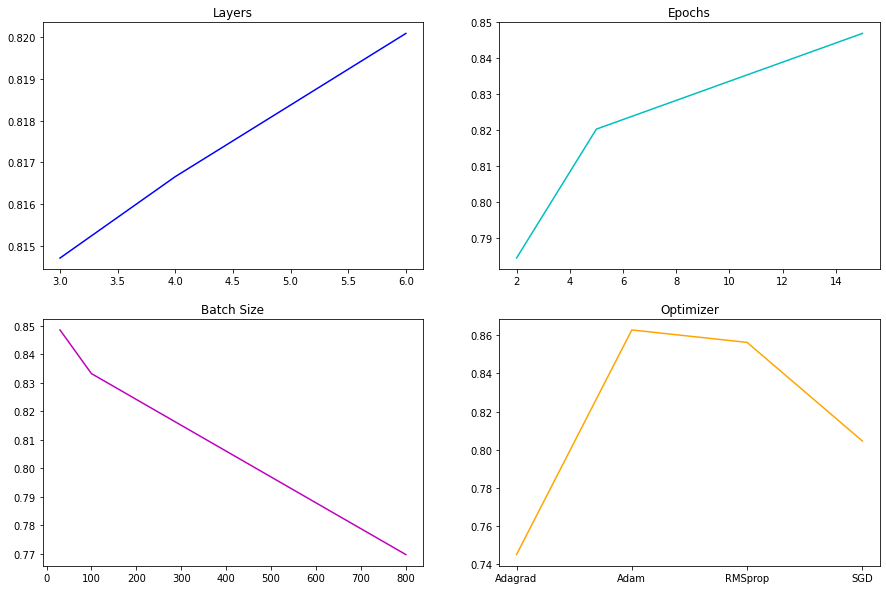

In [203]:
figure, axis = plt.subplots(2, 2, figsize=(15, 10))

df = results.groupby(['layers'], as_index=False).mean(numeric_only=False)
axis[0, 0].plot(df['layers'],df['accuracy'],color='b')
axis[0, 0].set_title("Layers")
  
df = results.groupby(['epochs'], as_index=False).mean(numeric_only=False)
axis[0, 1].plot(df['epochs'],df['accuracy'],color='c')
axis[0, 1].set_title('Epochs')
  
df = results.groupby(['batch_size'], as_index=False).mean(numeric_only=False)
axis[1, 0].plot(df['batch_size'],df['accuracy'],color='m')
axis[1, 0].set_title("Batch Size")
  
df = results.groupby(['optimizer'], as_index=False).mean(numeric_only=False)
axis[1, 1].plot(df['optimizer'],df['accuracy'],color='orange')
axis[1, 1].set_title("Optimizer")
  

plt.show()

In [213]:
np.random.seed(26)
neurons = [8,64,128,200, 256, 300]
results=[]
for neu in neurons:
    acc = evaluate_model(4, 15, 30, 'Adam', i)
    results.append(acc)

Text(0, 0.5, 'Accuracy')

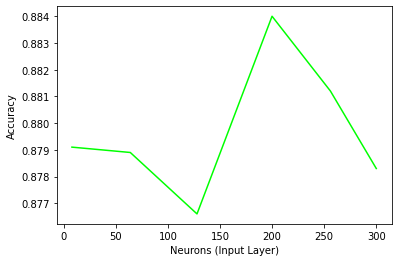

In [214]:
plt.plot(neurons, results,'lime')
plt.xlabel('Neurons (Input Layer)')
plt.ylabel('Accuracy')

In [215]:
results[3]

0.8840000033378601

In [218]:
model = Sequential(name='fashion_model')
model.add(Dense(200, activation='relu', input_shape=(28*28,)))
for k in range(1):
    model.add(Dense(10+(10-k)*10, activation='tanh'))

model.add(Dense(10,activation='softmax'))
    
model.compile(
    optimizer='Adam',
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'])

In [221]:
model.fit(train_img[:,:],
         train_labels_cat[:,:],
         epochs=15,
         batch_size=32,
         validation_split=0.2,
         verbose=0)

In [231]:
model.evaluate(test_img, test_labels_cat,verbose=0)

[0.341055691242218, 0.8859000205993652]

In [222]:
preds = model.predict(test_img)
preds_class = np.argmax(preds, axis=1)
test_class = np.argmax(test_labels_cat, axis=1)

313/313 [==============================] - 1s 3ms/step


In [224]:
class_names = ['T-shirt/top',
               'Trouser',
               'Pullover',
               'Dress',
               'Coat',
               'Sandal',
               'Shirt',
               'Sneaker',
               'Bag',
               'Ankle boot']

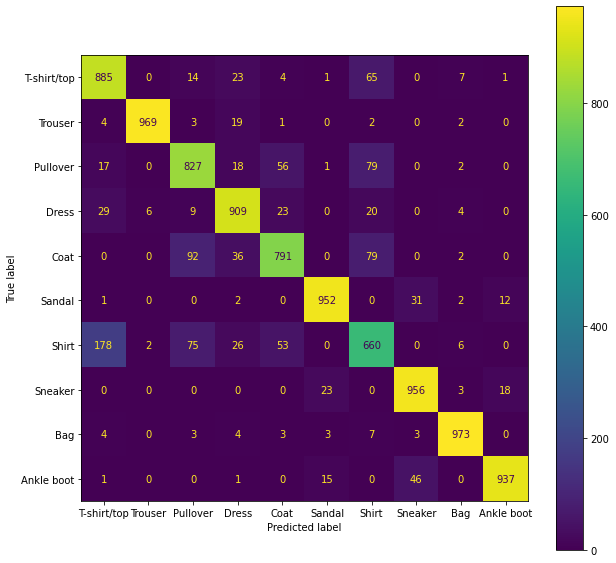

In [225]:
# Визуализируем матрицу ошибок
cm=confusion_matrix(test_class,preds_class)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
plt.show()

In [227]:
unique_test, counts_test = np.unique(test_class, return_counts=True)
unique_pred, counts_pred = np.unique(preds_class, return_counts=True)

In [228]:
# Рассчитываем полноту и точность для классов
recall = {}
precision = {}
trues = []
for i in range(len(test_class)):
    if test_class[i]==preds_class[i]:
        trues.append(test_class[i])
        
for i in range(10):
    recall[i] = trues.count(i) * 100 / counts_test[i]
    precision[i] = trues.count(i) * 100 / counts_pred[i]

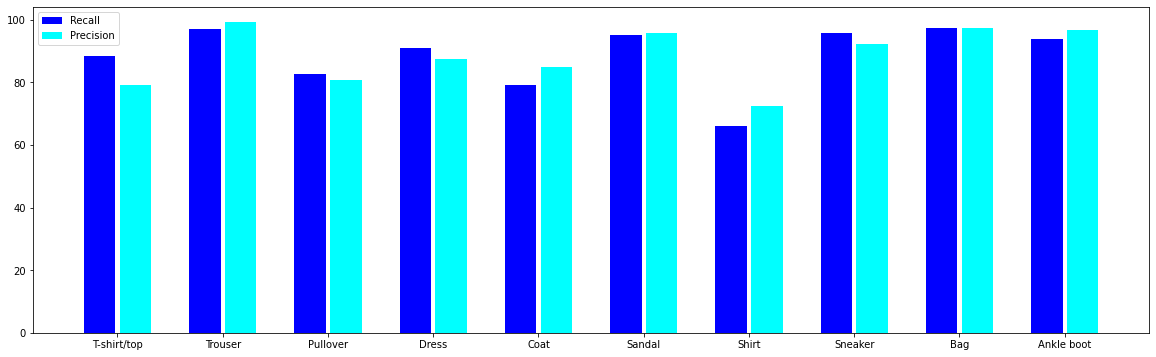

In [229]:
x = np.arange(10)#list(recall.keys()))
fig, ax = plt.subplots(figsize=(20, 6))
plt.bar (x-0.17, list(recall.values()), color='blue', alpha=1,width=0.3,label='Recall')
plt.bar (x+0.17, list(precision.values()), alpha=1,color='cyan', width=0.3,label='Precision')
plt.legend()
ax.set_xticks(x)
ax.set_xticklabels(class_names)
plt.show()